# Лабораторная работа №7 Предсказание пола клиента по транзакциям

## Сергеев Никита

### Считывание данных

In [2]:
import pandas as pd
import numpy as np

import xgboost as xgb
import re
import matplotlib.pyplot as plt

#from tqdm.notebook import tqdm_notebook
from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')

In [3]:
# Считываем данные
tr_mcc_codes = pd.read_csv('../data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('../data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('../data/transactions.csv', index_col='customer_id')
print(transactions.describe())
gender_train = pd.read_csv('../data/gender_train.csv', index_col='customer_id')
gender_test = pd.DataFrame(columns=['gender'], index = list(set(transactions.index) - set(gender_train.index)))
# gender_test = pd.read_csv('./data/gender_test_kaggle_sample_submission.csv', index_col='customer_id')

transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')
print(f'Всего уникальных клиентов: {transactions.index.nunique()}')
print(f'Всего уникальных клиентов с известным полом (train): {transactions_train.index.nunique()}')
print(f'Всего уникальных клиентов с неизвестным полом (test): {transactions_test.index.nunique()}')

           mcc_code       tr_type        amount
count  6.849346e+06  6.849346e+06  6.849346e+06
mean   5.589776e+03  2.517356e+03 -2.054285e+04
std    6.035857e+02  2.270108e+03  4.777528e+05
min    7.420000e+02  1.000000e+03 -1.459845e+08
25%    5.200000e+03  1.030000e+03 -2.245916e+04
50%    5.641000e+03  1.110000e+03 -5.480030e+03
75%    6.010000e+03  2.370000e+03 -1.122960e+03
max    9.402000e+03  8.146000e+03  1.459845e+08
Всего уникальных клиентов: 15000
Всего уникальных клиентов с известным полом (train): 8400
Всего уникальных клиентов с неизвестным полом (test): 6600


In [4]:
transactions

,tr_datetime,mcc_code,tr_type,amount,term_id
customer_id,,,,,
39026145,0 10:23:26,4814,1030,-2245.92,NaN
39026145,1 10:19:29,6011,7010,56147.89,NaN
39026145,1 10:20:56,4829,2330,-56147.89,NaN
39026145,1 10:39:54,5499,1010,-1392.47,NaN
39026145,2 15:33:42,5499,1010,-920.83,NaN
...,...,...,...,...,...
61870738,453 16:03:02,5499,1010,-5176.84,10217113
61870738,454 10:54:60,5411,1010,-1652.77,022915
61870738,454 14:23:59,5499,1010,-4687.23,10217113


## Определение пола клиента 

In [5]:
# Добавим дополнительные признаки по каждому пользователю в модель.
# Для этого будем анализировать дни недели, часы и состояние дня/ночи.
for df in [transactions_train, transactions_test]:
    df['weekday'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['isday'] = df['hour'].between(6, 22).astype(int)

transactions_train.sample
def features_creation(x): 
    '''Формирование признаков по каждому пользователю'''
    
    features = []

    # ВременнЫе признаки
    features.append(pd.Series(x['weekday'].value_counts(normalize=True).add_prefix('weekday_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['isday'].value_counts(normalize=True).add_prefix('isday_')))
    
    # Стандартные агрегации, посчитанные на расходах и приходах клиента: 
    # минимум, максимум, среднее, медиана, среднеквадратичное отклонение, количество
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))

    # Типы транзакций 
    features.append(pd.Series(x['mcc_code'].value_counts(normalize=True).add_prefix('mcc_code_')))
    # Типы mcc кодов
    features.append(pd.Series(x['tr_type'].value_counts(normalize=True).add_prefix('tr_type_')))

    # ДОПОЛНИТЕЛЬНЫЕ ПАРАМЕТРЫ
    # ....
    
    return pd.concat(features)
data_train = transactions_train.groupby(transactions_train.index).apply(features_creation).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index).apply(features_creation).unstack(-1)

In [6]:
def cv_score(params, train, y_true):
    '''Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)'''
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print(f'Cross-validation, ROC AUC: {cv_res.loc[index_argmax]["test-auc-mean"]:.3f}+-{cv_res.loc[index_argmax]["test-auc-std"]:.3f}')
    print(f'Trees: {index_argmax}')
def fit_predict(params, num_trees, train, test, target):
    '''Построение модели + возврат результатов классификации тестовых пользователей'''
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission
def draw_feature_importances(clf, top_k=10):
    '''Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
    в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
    '''
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()
# Стандартные параметры модели
# !!! Здесь можно и НУЖНО экспериментировать

params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

Cross-validation, ROC AUC: 0.877+-0.006
Trees: 178


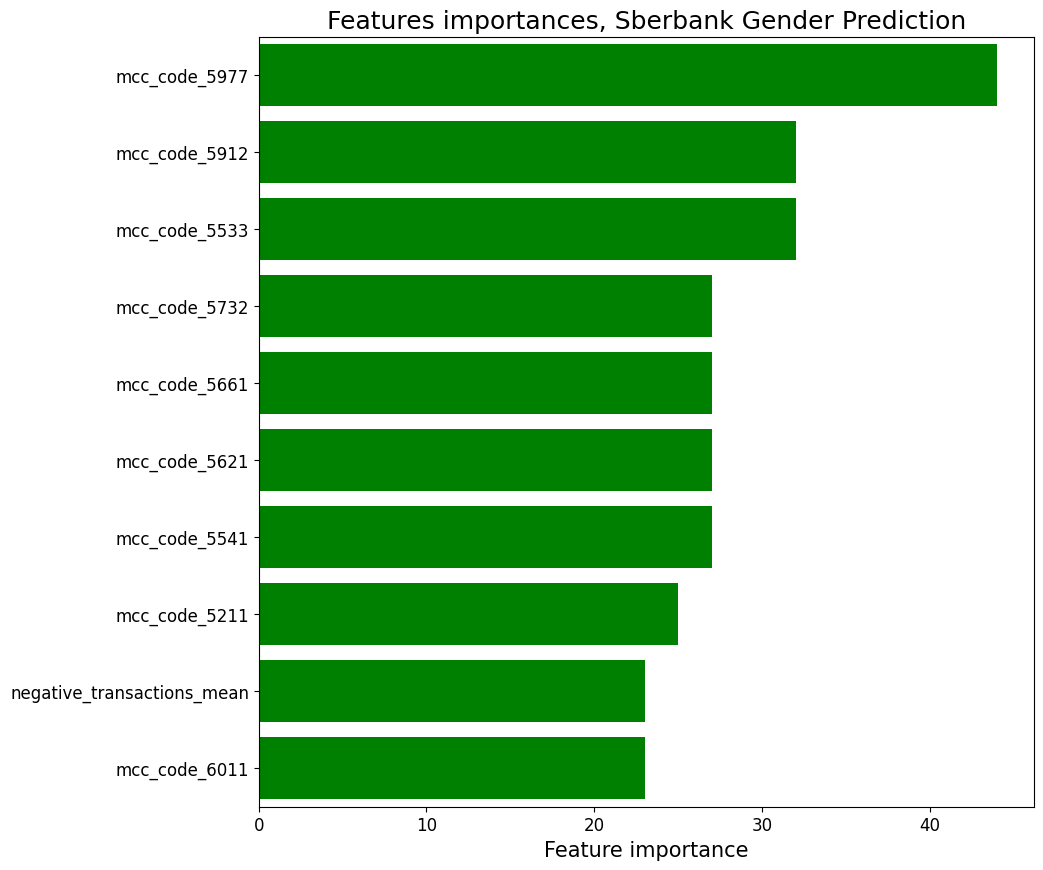

In [7]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)
### Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 180, data_train, data_test, target)
draw_feature_importances(clf, 10)
# В итоге можем отправить полученное решение на платформу Kaggle. 
# Для этого выгрузим его в *.csv - файл, после чего полученный файл можем загружать в качестве ответа.
submission.to_csv('../data/submission.csv')

In [8]:
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.9, #######
    'colsample_bytree': 0.9, #######
    
    'gamma': 0.1, # 0.1 # 0.2 # 0.8
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)
### Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
#clf, submission = fit_predict(params, 180, data_train, data_test, target)
#draw_feature_importances(clf, 10)
# В итоге можем отправить полученное решение на платформу Kaggle. 
# Для этого выгрузим его в *.csv - файл, после чего полученный файл можем загружать в качестве ответа.
#submission.to_csv('./data/submission.csv')

Cross-validation, ROC AUC: 0.878+-0.006
Trees: 187


## Задание 1. Вычисление даты

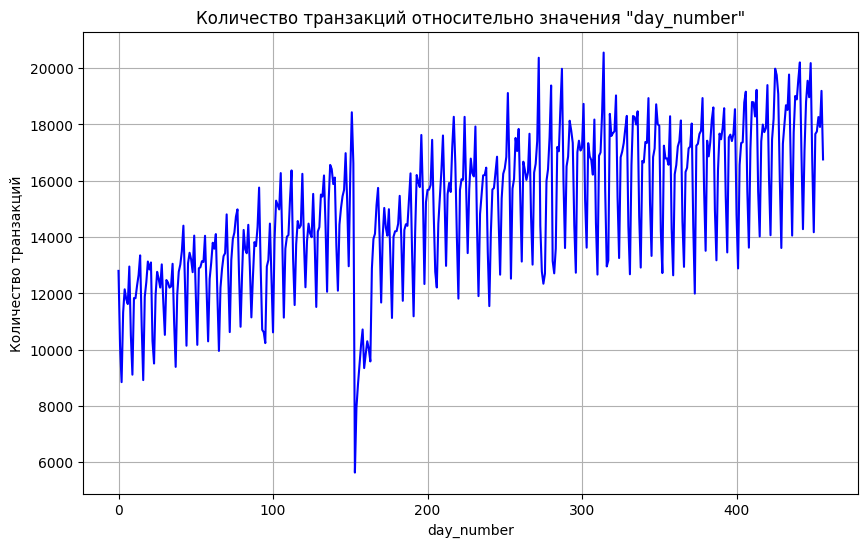

In [9]:
df = transactions

# Разделение строки по пробелу и создание нового столбца
df['day_number'] = df['tr_datetime'].str.split(' ', expand=True)[0]

# Преобразование значения в числовой формат
df['day_number'] = df['day_number'].astype(int)

# Группировка данных по 'day_number' и подсчет количества транзакций
transaction_counts = df.groupby('day_number').size()

plt.figure(figsize=(10, 6))
plt.plot(transaction_counts.index, transaction_counts.values, marker=None, linestyle='-', color='b')
plt.title('Количество транзакций относительно значения "day_number"')
plt.xlabel('day_number')
plt.ylabel('Количество транзакций')
plt.grid(True)
plt.show()

Основные параметры:
Количество дней между 1 января и 14 февраля = 45
Количество дней между 1 января и 23 февраля = 54
Количество дней между 1 января и 8 марта = 67 или 68 в високосный год
Количество дней между 1 января и 1 сентября = 243 или 244 в високосный год

5921;Магазины с продажей спиртных напитков на вынос (пиво, вино и ликер)
5813;Бары, коктейль-бары, дискотеки, ночные клубы и таверны — места продажи алкогольных напитков

5621;Готовая женская одежда
5631;Аксессуары для женщин

5532;Автошины
5533;Автозапчасти и аксессуары
5541;Станции техобслуживания
5542;Автоматизированные бензозаправки
5571;Продажа мотоциклов
5599;Продажа снегоходов

5943;Магазины офисных, школьных принадлежностей, канцтоваров

5977;Магазины косметики

In [10]:
df = transactions

# Разделение строки по пробелу и создание нового столбца
df['day_number'] = df['tr_datetime'].str.split(' ', expand=True)[0]

# Преобразование значения в числовой формат
df['day_number'] = df['day_number'].astype(int)

# Группировка данных по 'day_number' и подсчет количества транзакций
transaction_counts = df.groupby('day_number').size()

# Фильтрация номеров дней, где было больше 19000 транзакций
days_with_more_than_19000 = transaction_counts[transaction_counts > 19800].index

print("Номера дней с более чем 19000 транзакций:", days_with_more_than_19000)

# Фильтрация номеров дней, где было больше 19000 транзакций
days_with_less_than_8000 = transaction_counts[transaction_counts < 8000].index
print("Номера дней с менее чем 8000 транзакций:", days_with_less_than_8000)

Номера дней с более чем 19000 транзакций: Index([272, 287, 314, 425, 441, 448], dtype='int32', name='day_number')
Номера дней с менее чем 8000 транзакций: Index([153, 154], dtype='int32', name='day_number')


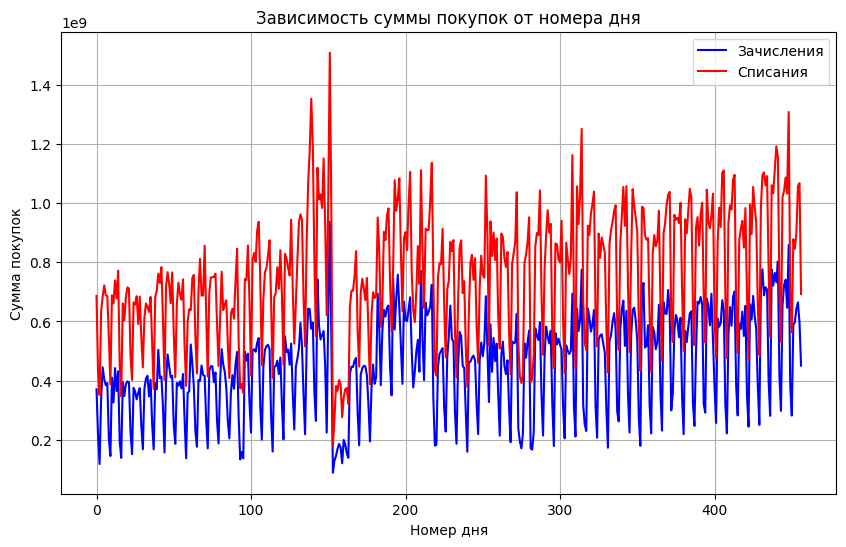

In [11]:
# Разделение DataFrame на положительные и отрицательные суммы
positive_df = df[df['amount'] > 0]
negative_df = df[df['amount'] < 0]

# Убираем минусы у отрицательных сумм
negative_df['amount'] = -negative_df['amount']

# Группировка данных по 'day_number' и подсчет суммы для каждого дня
positive_amounts = positive_df.groupby('day_number')['amount'].sum()
negative_amounts = negative_df.groupby('day_number')['amount'].sum()

# Построение графика
plt.figure(figsize=(10, 6))

# Ломаная линия для положительных сумм
plt.plot(positive_amounts.index, positive_amounts.values, label='Зачисления', linestyle='-', color='b')

# Ломаная линия для отрицательных сумм
plt.plot(negative_amounts.index, negative_amounts.values, label='Списания', linestyle='-', color='r')

plt.title('Зависимость суммы покупок от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма покупок')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Нахождение дней, в которые сумма трат была больше 1.2
days_with_negative_amounts_greater_than_1_2 = negative_amounts[negative_amounts > 1200000000].index

print("Дни, в которые сумма трат была больше 1.2:", days_with_negative_amounts_greater_than_1_2)

Дни, в которые сумма трат была больше 1.2: Index([139, 151, 314, 448], dtype='int32', name='day_number')


### Попытаемся найти 1 сентября

Знаем, что mmc код 5943 - это магазины офисных, школьных принадлежностей, канцтоваров

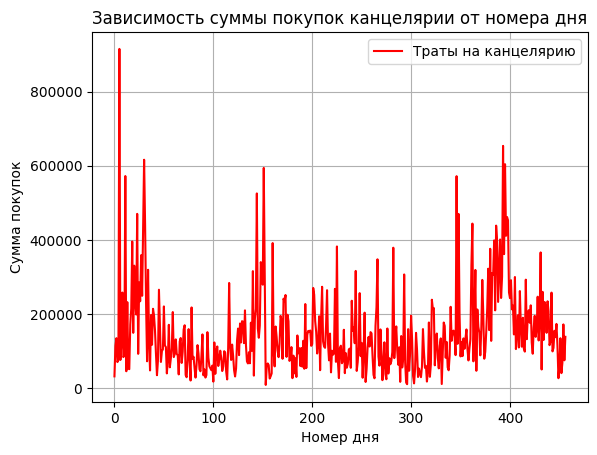

In [13]:
# shcool_time = negative_amounts[negative_amounts['mcc_code'] == 5943].groupby('day_number')['amount'].sum()

# Filter transactions with mcc_code equal to 5943 and negative amounts
filtered_transactions = df[(df['mcc_code'] == 5943) & (df['amount'] < 0)]

# Create a new DataFrame with day_number and the sum of negative amounts
school_time = filtered_transactions.groupby('day_number')['amount'].sum()

# Make the negative amounts positive
school_time = school_time.abs()

plt.plot(school_time.index, school_time.values, label='Траты на канцелярию', linestyle='-', color='r')

plt.title('Зависимость суммы покупок канцелярии от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма покупок')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Нахождение дней, в которые сумма трат была больше 1.2
first_sept = school_time[school_time > 600000].index

print("Предположительный конец августа:", first_sept)

Предположительный конец августа: Index([5, 30, 393, 395], dtype='int32', name='day_number')


### Попытаемся найти 8 марта

Знаем, что mmc код 5193 - Оборудование для выращивания растений, инвентарь для питомников и цветы

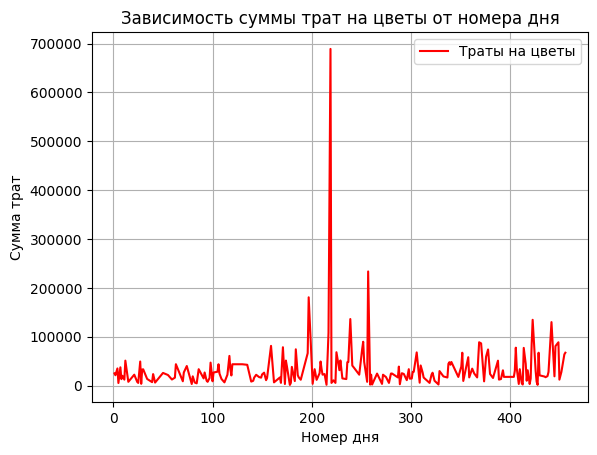

In [15]:
# Filter transactions with mcc_code equal to 5193 and negative amounts
filtered_transactions = df[(df['mcc_code'] == 5193) & (df['amount'] < 0)]

# Create a new DataFrame with day_number and the sum of negative amounts
March = filtered_transactions.groupby('day_number')['amount'].sum()

# Make the negative amounts positive
March = March.abs()

plt.plot(March.index, March.values, label='Траты на цветы', linestyle='-', color='r')

plt.title('Зависимость суммы трат на цветы от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма трат')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Нахождение дней, в которые сумма трат была больше 1.2
flover_time = March[March > 600000].index

print("Предположительное 8 марта:", flover_time)

Предположительное 8 марта: Index([219], dtype='int32', name='day_number')


219-й день - это 8 Марта

Дельта от 8 марта, до 153-го дня равна 66 дней, что как раз является расстоянием от 1 Января до 8 Марта

Отнимем от 1 января 153 дня (чтобы избежать проблем с високосным годом) и получим: 1 Августа

Значит датасет начинается с 1-го августа

## Теперь определим дни недели

Для этого нарисуем график зависимоти номера дня от суммы трат на алкоголь

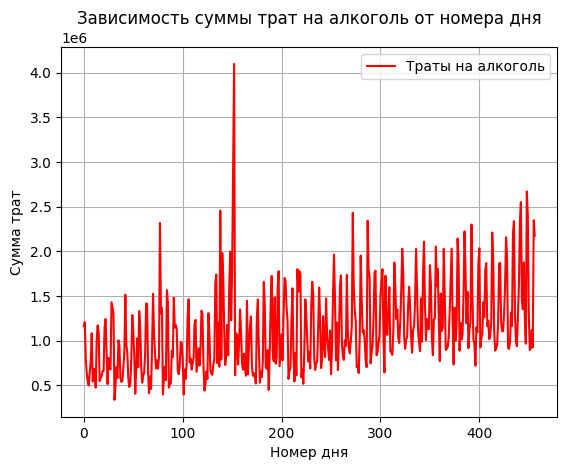

In [17]:
# 5921;Магазины с продажей спиртных напитков на вынос (пиво, вино и ликер)
filtered_transactions = df[(df['mcc_code'] == 5921) & (df['amount'] < 0)]

# Create a new DataFrame with day_number and the sum of negative amounts
Alcohol = filtered_transactions.groupby('day_number')['amount'].sum()

# Make the negative amounts positive
Alcohol = Alcohol.abs()

plt.plot(Alcohol.index, Alcohol.values, label='Траты на алкоголь', linestyle='-', color='r')

plt.title('Зависимость суммы трат на алкоголь от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма трат')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
New_year = Alcohol[Alcohol > 3000000].index

print("Предположительное нг:", New_year)

Предположительное нг: Index([151, 152], dtype='int32', name='day_number')


Возьмём первые 100 дней

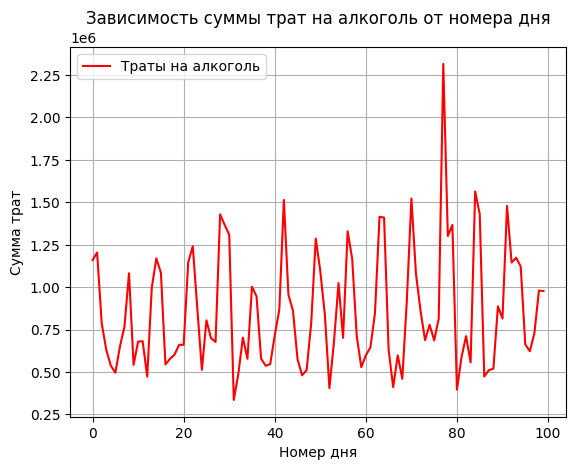

In [19]:
Alcohol_100 = Alcohol.head(100)

plt.plot(Alcohol_100.index, Alcohol_100.values, label='Траты на алкоголь', linestyle='-', color='r')

plt.title('Зависимость суммы трат на алкоголь от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма трат')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
fridays = Alcohol_100[Alcohol_100 > 1010000].index

print("Предположительные пятницы:", fridays)

Предположительные пятницы: Index([ 0,  1,  8, 14, 15, 21, 22, 28, 29, 30, 42, 49, 50, 54, 56, 57, 63, 64,
       70, 71, 77, 78, 79, 84, 85, 91, 92, 93, 94],
      dtype='int32', name='day_number')


Скорее всего 2 рядом стоящих дня - это пятница и субботы, а значит 14, 21, 28 и тд - пятницы.
8-е и 1-е - суббота.

Получаем начало отсчёта: пятница 1-го августа

### Определим год начала отсчёта

в 2008 и 2014 1-е августа было пятницей

######## Между 8 марта и 1 января 66 дней, а значит следующий за годом начала отсчёта год - не високосный (в високосном 67 дней)
2008 - високосный, а 2014 -нет. Значит отсчёт начался:

Попробуем сыграть от того, что в 2014 в Сочи была олимпиада, а значит с 7 по 23 февраля должен быть большое скачок продажи сувениров
7-23 февраля - это 190-206 дни

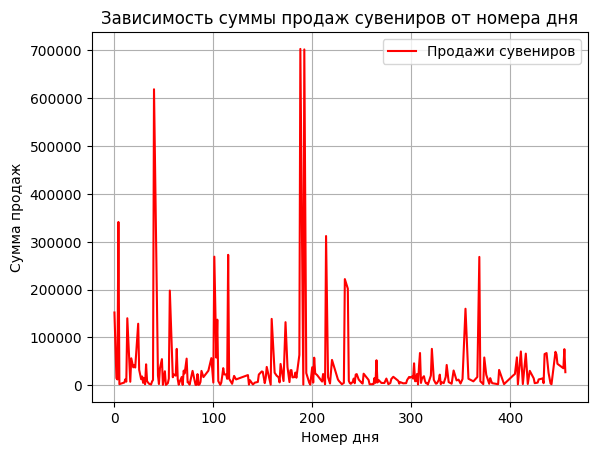

In [21]:
# 5947;Магазины открыток, подарков, новинок и сувениров
filtered_transactions = df[(df['mcc_code'] == 7372) & (df['amount'] < 0)]

Souvenir = filtered_transactions.groupby('day_number')['amount'].sum()

# Make the negative amounts positive
Souvenir = Souvenir.abs()

plt.plot(Souvenir.index, Souvenir.values, label='Продажи сувениров', linestyle='-', color='r')

plt.title('Зависимость суммы продаж сувениров от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма продаж')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
Souvenir_top = Souvenir[Souvenir > 2000000].index

print("Предположительные пятницы:", Souvenir_top)

Предположительные пятницы: Index([], dtype='int32', name='day_number')


## Пятница 1-е августа 2014 года

# Задание 2. Декодировать суммы поступлений и списаний.

Найдем этот коэффициент благодаря следующему tr_type: 2010;Выдача наличных в АТМ Сбербанк России

In [35]:
filtered_amounts = df[(df['tr_type'] == 2010) & (df['amount'] < 0)]['amount']
unique_amounts = filtered_amounts.unique()
sorted_unique_amounts = pd.Series(unique_amounts).astype(float).sort_values()

# Найдем разницу в суммах
differences = sorted_unique_amounts.diff()

print(differences)
# Посчитаем количество одинаковых разниц, чтобы найти самые популярные
differences_counts = differences.value_counts()

# Выводим топ-10 самых частых разностей
top_10_differences = differences_counts.head(10)
print("Топ-10 самых частых разностей:")
print(top_10_differences)

661          NaN
206     36755.54
566     89836.63
272     22459.15
1207    67377.48
          ...   
0        1122.96
962        94.78
112      1028.18
46       1122.95
21       1122.96
Length: 1332, dtype: float64
Топ-10 самых частых разностей:
2245.92     146
2245.92      85
2245.91      75
2245.91      69
1122.96      68
1122.96      64
4491.83      54
1122.96      39
11229.58     38
2245.91      37
Name: count, dtype: int64


2245.92 - это вероятно 100 рублей, а 1122.96 - это 50 рублей, а значит коэффициент равен **22.4592**